In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
df=pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


First: Exploration and Charts( Credits to Kaggle user: ZHAOHAN ZENG) for the graphs code

Boxplots for Outlier Detection

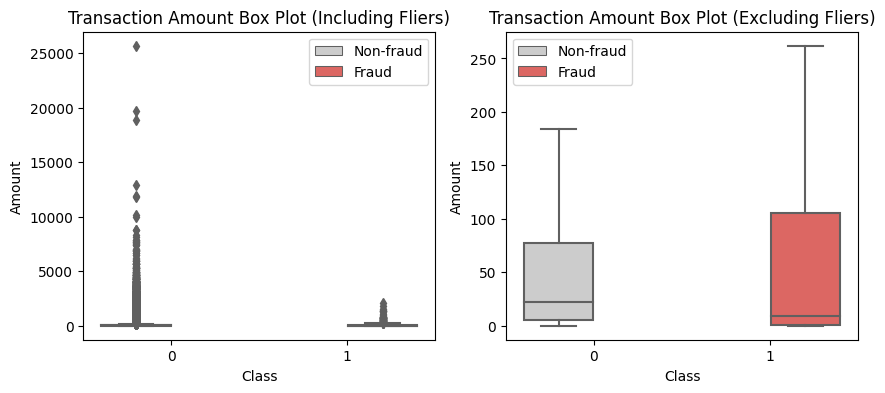

In [3]:
# Custom colors for data

gray_color = "#CCCCCC" # Grey for regular txs
red_color = "#F0544F" # Red for fraudulent txs
blue_color = "#8CA6F2" # Blue for heatmap
gold_color = '#F2D98C' # Gold for heatmap
green_color = '#A4F28C'# Green for confusion matrix
white_color = '#FFFFFF' # White for confusion matrix

color_pal = [gray_color, red_color]

fig, ax = plt.subplots(ncols=2, figsize=(10,4))

sns.boxplot(data=df, 
            x="Class", 
            y="Amount", 
            hue="Class",
            palette=color_pal,
            showfliers=True,
            ax=ax[0])

sns.boxplot(data=df, 
            x="Class", 
            y="Amount", 
            hue="Class",
            palette=color_pal,
            showfliers=False,
            ax=ax[1])

# Add titles to the plots
ax[0].set_title("Transaction Amount Box Plot (Including Fliers)")
ax[1].set_title("Transaction Amount Box Plot (Excluding Fliers)")

# Update legend labels
legend_labels = ['Non-fraud', 'Fraud']
for i in range(2):
    handles, _ = ax[i].get_legend_handles_labels()
    ax[i].legend(handles, legend_labels)


plt.show()

ScatterPlot for Amount Distribution

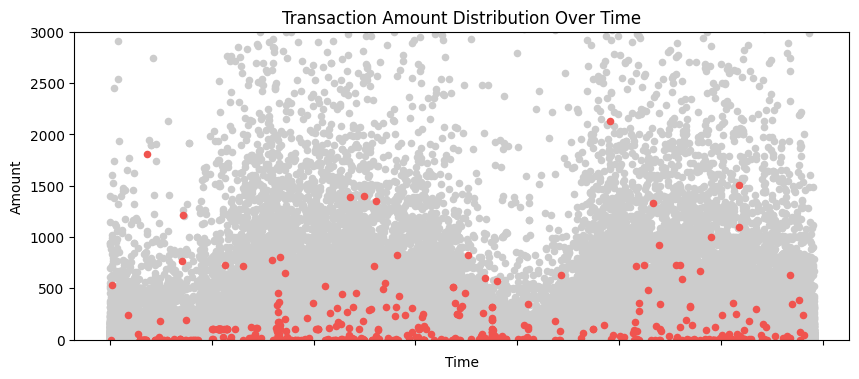

In [4]:
f, ax = plt.subplots(figsize=(10, 4))

sns.scatterplot(data=df.loc[df.Class==0], 
                x='Time', 
                y='Amount', 
                color=gray_color,
                s=30,
                alpha=1,
                linewidth=0)

ax.set(xlabel=None, xticklabels=[])
plt.ylim(0, 3000)


sns.scatterplot(data=df.loc[df.Class==1], 
                x='Time', 
                y='Amount', 
                color=red_color,
                s=30,
                alpha=1,
                linewidth=0)
plt.ylim(0, 3000)

# Add title to the plot
ax.set_title("Transaction Amount Distribution Over Time")

plt.show()

Feature Comparison of Each Class

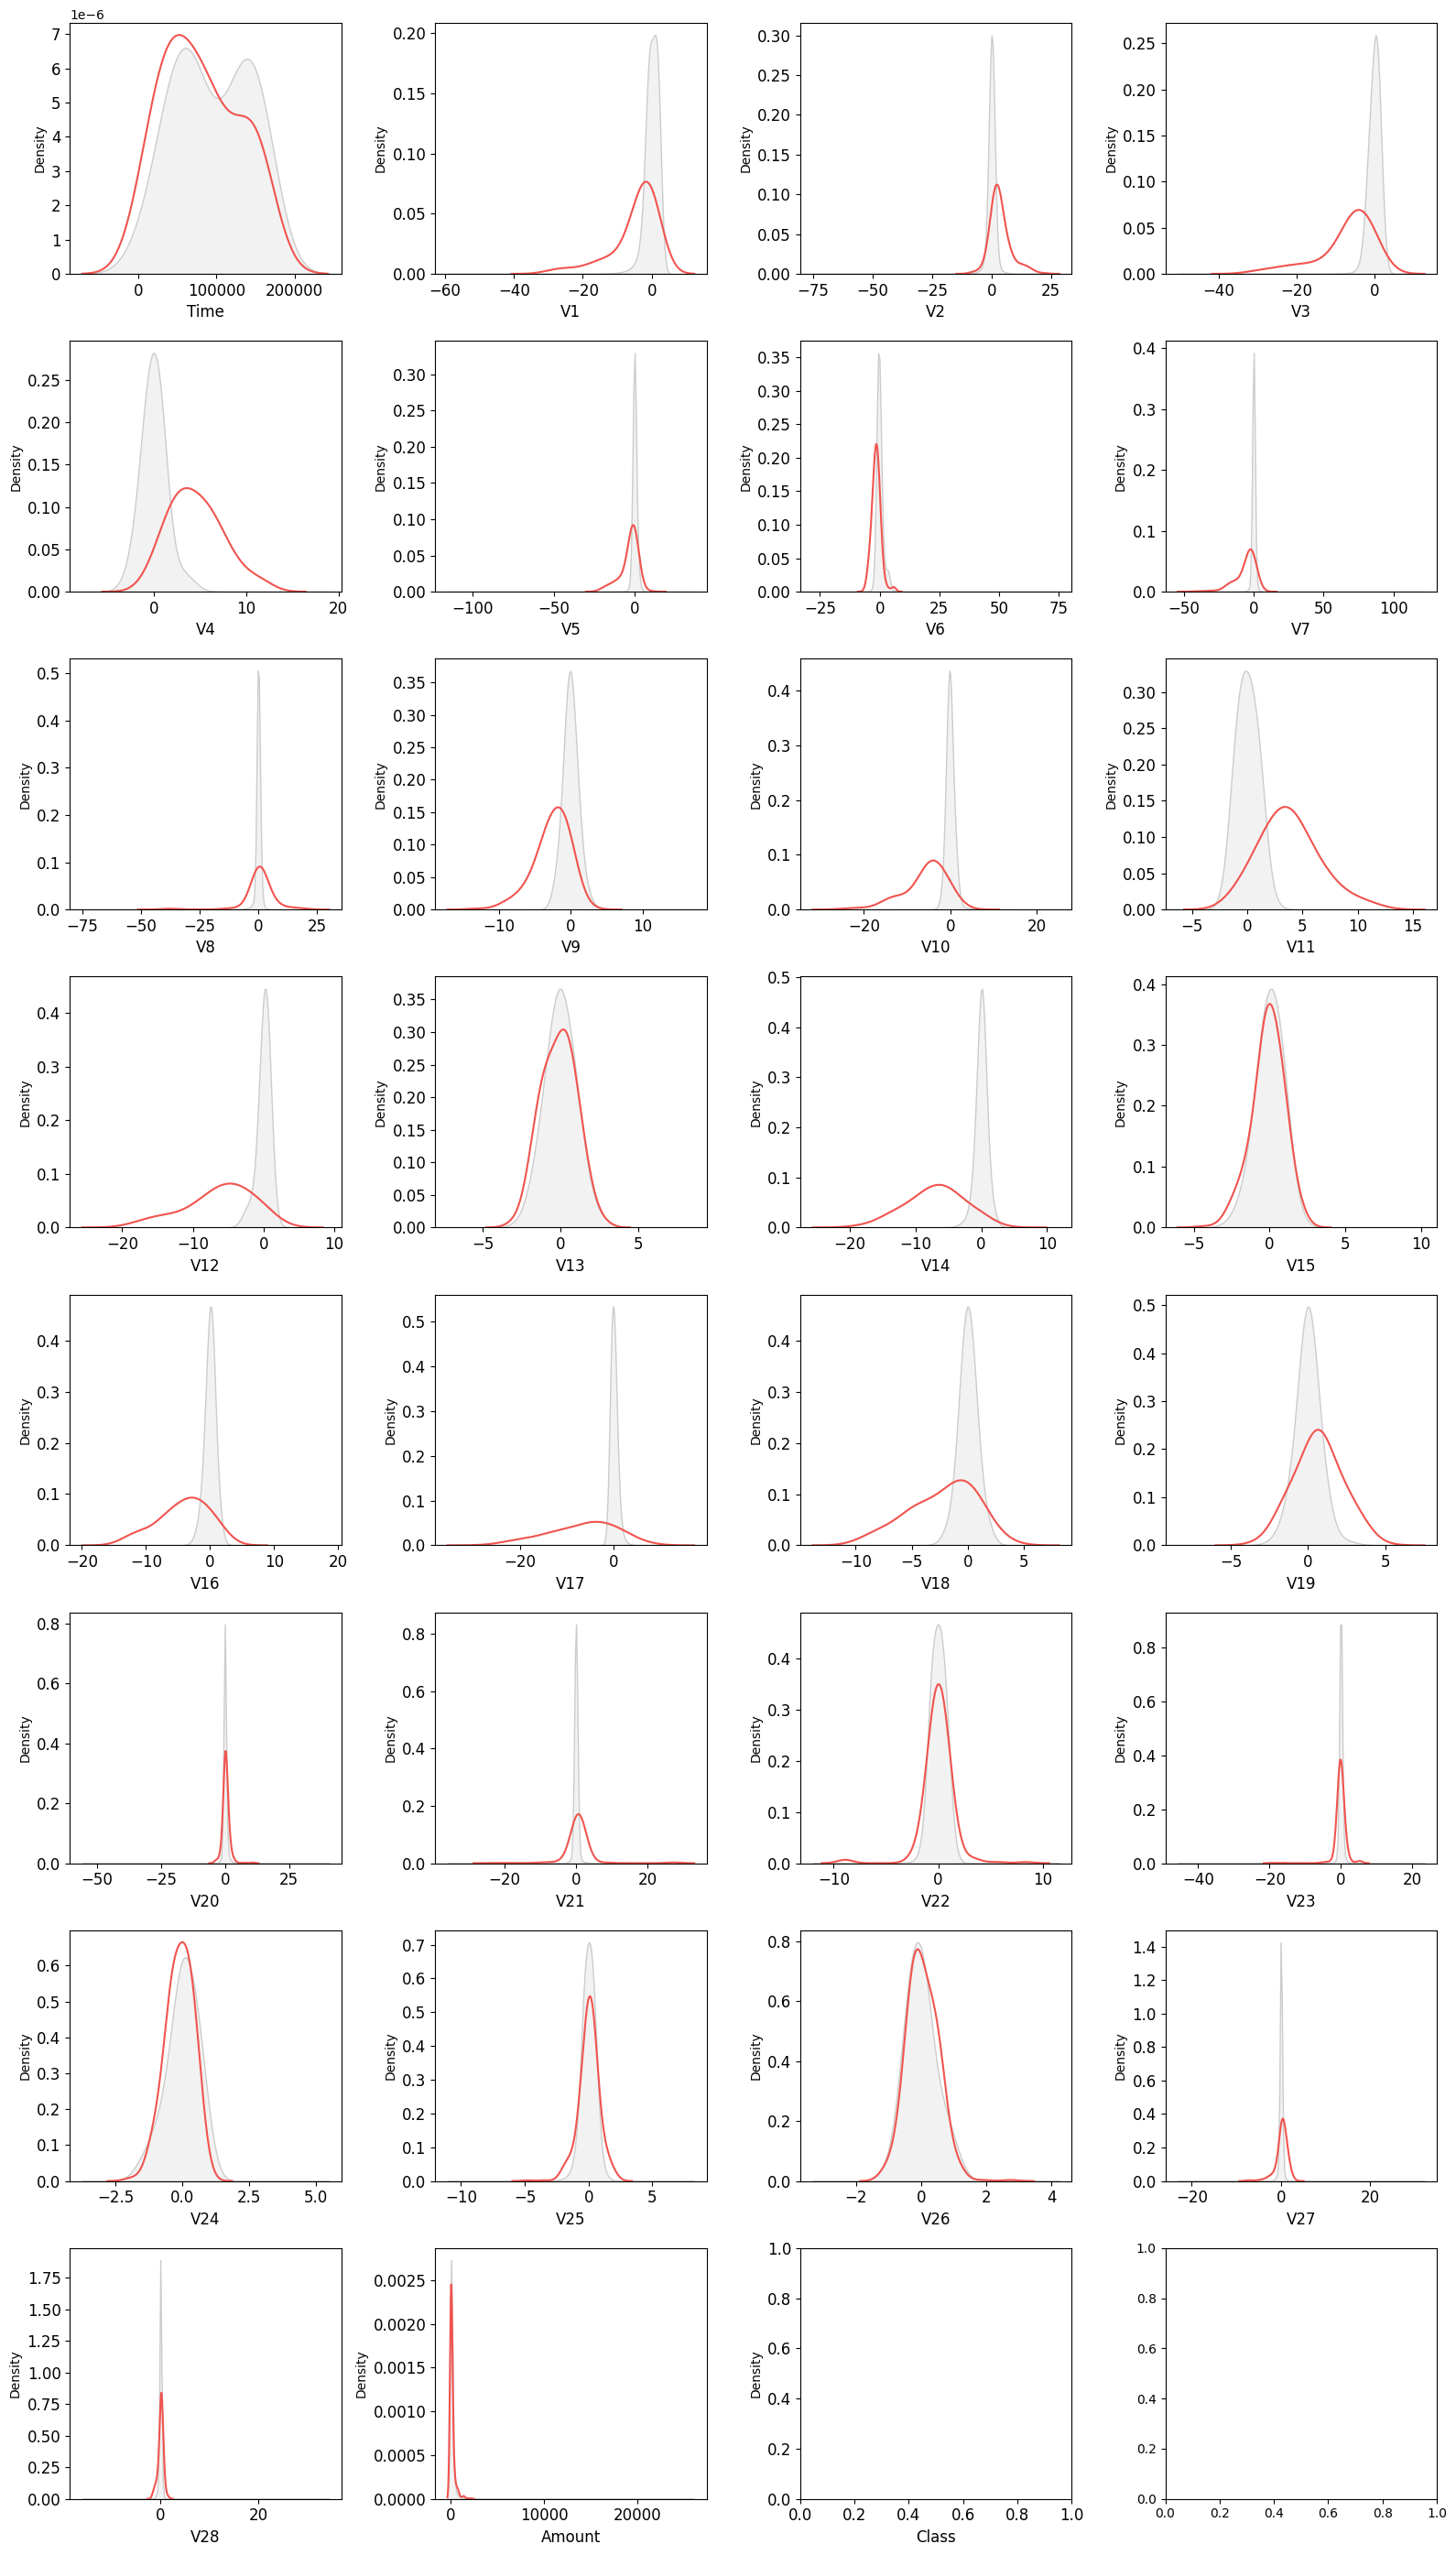

In [5]:
var = df.columns.values

t0 = df.loc[df['Class'] == 0]
t1 = df.loc[df['Class'] == 1]

num_features = len(var)
num_rows = num_features // 4 + int(num_features % 4 != 0)

fig, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=(16, 28))

for idx, feature in enumerate(var):
    row = idx // 4
    col = idx % 4
    
    sns.kdeplot(t0[feature], bw_method=0.5, label="Class = 0", color=gray_color, fill=True, warn_singular=False, ax=ax[row, col])
    sns.kdeplot(t1[feature], bw_method=0.5, label="Class = 1", color=red_color, warn_singular=False, ax=ax[row, col])
    
    ax[row, col].set_xlabel(feature, fontsize=12)
    ax[row, col].tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

Second: The Models

Logistic Classification Pipeline with imputer and scaler 

In [6]:
pipeLog=Pipeline(
[
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('logClass',LogisticRegression())
])

Random Forest Classifier Pipeline with imputer and scaler

In [7]:
pipeForest=Pipeline(
[
    ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    ('forestClass',RandomForestClassifier())
])

Train Test Split

In [8]:
X=df.drop(["Class"],axis=1)
y=df["Class"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=20)

Comparison

In [9]:
logScore=pipeLog.fit(X_train,y_train).score(X_test,y_test)
forestScore=pipeForest.fit(X_train,y_train).score(X_test,y_test)
print("LogisticRegression Score is ",logScore)
print("RandomForestClassifier Score is ",forestScore)

LogisticRegression Score is  0.9991397773954567
RandomForestClassifier Score is  0.9995611109160493
